# Valet Parking

Calculate new parked positions for non-functional robots. See this [interactive demo](https://observablehq.com/@dkirkby/robot-valet-parking) for details.

### Imports

In [1]:
import pathlib
import itertools
from collections import namedtuple

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
from scipy.spatial import ConvexHull

In [4]:
import astropy.time

In [5]:
import fpoffline.db
import fpoffline.io
import fpoffline.const
import fpoffline.keepout

Not using DOS logging. Log messages will not be recorded


### Initial Focalplane State

Use an offline snapshot to establish the initial state of the focal plane that we will optimize.

Running at NERSC, you can find the latest snapshot using:
```
import fpoffline.io

snap = fpoffline.io.get_snapshot()
```

Here, we use a fixed version stored in this repo instead:

In [6]:
when = astropy.time.Time('2025-04-05T00:00:00', format='isot', scale='utc')
snap, _ = fpoffline.io.get_snapshot(when, path=pathlib.Path('.'))

Define a helper function to return the snapshot entry for a specified POS_ID:

In [7]:
lookup = { dev['POS_ID']: snap[k] for k, dev in enumerate(snap) }

Lookup useful petal constants:

In [8]:
PTL = fpoffline.const.get_petal_design()

Create a boolean mask of non-functional robot locations:

In [9]:
nonfunc = np.zeros((10, 514), bool)
for dev in snap:
    if dev['DEVICE_CLASSIFIED_NONFUNCTIONAL']:
        nonfunc[dev['PETAL_LOC'], PTL.locmap[dev['DEVICE_LOC']]] = True

Look up the calibration data at the time of the snapshot. Almost all of this information is already in the snapshot, except for the flag (`zeno_motor_p`) that identifies recovered linear phi robots.

In [10]:
DB = fpoffline.db.DB()

In [11]:
calib = fpoffline.scripts.endofnight.get_calib(DB, at=snap.meta['DATE_RETRIEVED'])

Loaded 502 calib rows for petal_id 4
Loaded 502 calib rows for petal_id 5
Loaded 502 calib rows for petal_id 6
Loaded 502 calib rows for petal_id 3
Loaded 507 calib rows for petal_id 8
Loaded 506 calib rows for petal_id 10
Loaded 503 calib rows for petal_id 11
Loaded 510 calib rows for petal_id 2
Loaded 502 calib rows for petal_id 7
Loaded 502 calib rows for petal_id 9


### Find Non-Overlapping Groups of Non-Functional Robots

In [12]:
def findGroups(snap):

    visited = set()

    def visit(dev, group):
        #print('visit', dev['POS_ID'], dev['DEVICE_CLASSIFIED_NONFUNCTIONAL'], dev['POS_NEIGHBORS'], group, visited)
        group.add(dev['POS_ID'])
        if dev['DEVICE_CLASSIFIED_NONFUNCTIONAL']:
            visited.add(dev['POS_ID'])
            for neighbor in dev['POS_NEIGHBORS']:
                if neighbor not in visited:
                    visit(lookup[neighbor], group)
        return group

    found = []
    for k, dev in enumerate(snap):
        if dev['POS_ID'] not in visited and dev['DEVICE_CLASSIFIED_NONFUNCTIONAL']:
            found.append(list(visit(dev, set())))

    groups = []
    for group in found:
        func, nonfunc = [], []
        for posid in group:
            if lookup[posid]['DEVICE_CLASSIFIED_NONFUNCTIONAL']:
                nonfunc.append(posid)
            else:
                func.append(posid)
        groups.append(namedtuple('Group', ['func', 'nonfunc'])(func, nonfunc))

    return groups

In [13]:
groups = findGroups(snap)

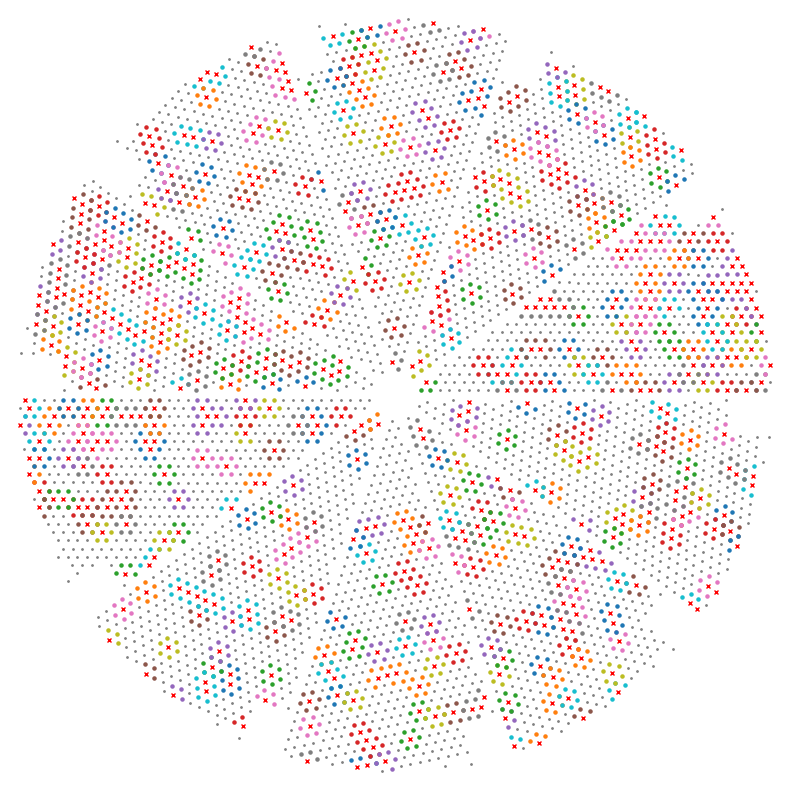

In [14]:
def plotGroups(groups):

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(PTL.xfp, PTL.yfp, s=1, c='gray')
    ax.plot(PTL.xfp[nonfunc], PTL.yfp[nonfunc], 'rx', ms=3)

    for group in groups:
        # Get CS5 coords (x,y) for each robot in this group
        x, y = [], []
        for posid in group.func:
            # Get CS5 coords (x,y) for each robot in this group
            dev = lookup[posid]
            ptl = dev['PETAL_LOC']
            idx = PTL.locmap[dev['DEVICE_LOC']]
            x.append(PTL.xfp[ptl, idx])
            y.append(PTL.yfp[ptl, idx])
        ax.scatter(x, y, s=5, marker='o')
    ax.set(xlim=(-420,420), ylim=(-420, 420), aspect=1)
    ax.axis('off')

plotGroups(groups)

### Keepout Polygons Calculations

Each robot has a keepout polygon defined for its theta and phi arms. See [this notebook](https://github.com/desihub/fpoffline/blob/main/nb/Keepouts/Keepouts.ipynb) for details.

First, verify that the computed polygons stored in the snapshot match what we calculate from the calibration data:

In [15]:
def verifyKeepouts(snap, calib):

    badT, badP = [ ], [ ]
    for dev in snap:
        poly_T1, poly_P1 = fpoffline.keepout.adjusted_keepouts_from_snapshot(snap, dev['POS_ID'])
        poly_T2, poly_P2 = fpoffline.keepout.adjusted_keepouts_from_calib(calib, dev['POS_ID'])
        if not np.allclose(poly_T1, np.round(poly_T2, 5)):
            badT.append(dev['POS_ID'])
        if not np.allclose(poly_P1, np.round(poly_P2, 5)):
            badP.append(dev['POS_ID'])
    print('badT', len(badT), ','.join(badT))
    print('badP', len(badP), ','.join(badP))

verifyKeepouts(snap, calib)

badT 0 
badP 0 


Next, generate the keepout to use for each robot.

In [16]:
def getConvexHull(x, y):
    pts = np.array([x, y]).T
    hull = ConvexHull(pts)
    return pts[hull.vertices]

In [17]:
def getKeepouts(calib, reset_nonfunc=True):

    assert reset_nonfunc == False, 'not implemented yet'

    keepouts = { }

    for posid in calib.pos_id:

        (polyTx,polyTy), (polyPx,polyPy) = fpoffline.keepout.adjusted_keepouts_from_calib(calib, posid)

        # Colculate convex hulls.
        polyT = getConvexHull(polyTx, polyTy)
        polyP = getConvexHull(polyPx, polyPy)

        keepouts[posid] = ( polyT, polyP )

    return keepouts

keepouts = getKeepouts(calib, reset_nonfunc=False)

In [18]:
def getRotatedKeepouts(posid, T, P, calib):
    """T,P must be input in radians!
    """
    T = np.asarray(T)
    P = np.asarray(P)
    assert np.all(np.abs(T) <= 2 * np.pi), 'T must be in radians'
    assert T.shape == P.shape, 'T and P must have the same shape'
    assert T.ndim <= 1, 'T and P must be scalars or 1D arrays'
    scalar = T.ndim == 0
    if scalar:
        T = np.array([T])
        P = np.array([P])

    polyT, polyP = keepouts[posid]

    cosT, sinT = np.cos(T), np.sin(T)
    cosTP, sinTP = np.cos(T + P), np.sin(T + P)

    sel = calib.pos_id == posid
    assert np.sum(sel) == 1, 'posid not found in calib'
    x0, y0 = float(calib.offset_x[sel]), float(calib.offset_y[sel])
    r1 = float(calib.length_r1[sel])
    x1, y1 = x0 + r1 * cosT, y0 + r1 * sinT

    RT = np.array(((cosT, -sinT), (sinT, cosT)))
    keepoutT = np.einsum('ijn,mj->nmi', RT, polyT) + np.array([x0, y0])

    RTP = np.array(((cosTP, -sinTP), (sinTP, cosTP)))
    keepoutP = np.einsum('ijn,mj->nmi', RTP, polyP) + np.array([x1,y1]).T.reshape(-1, 1, 2)

    if scalar:
        keepoutT = keepoutT.reshape(-1, 2)
        keepoutP = keepoutP.reshape(-1, 2)

    return keepoutT, keepoutP

#getRotatedKeepouts('M02754', [0,0], [0,0], calib)

In [19]:
def get_axes(polygon):
    edges = polygon - np.roll(polygon, -1, axis=0)
    normals = np.stack([-edges[:,1], edges[:,0]], axis=-1)
    return normals / np.linalg.norm(normals, axis=-1, keepdims=True)

def project_polygon(polygon, axes):
    projections = np.dot(polygon, axes.T)
    return np.min(projections, axis=0), np.max(projections, axis=0)

def polygons_overlap_sat(poly1, poly2):
    axes = np.vstack((get_axes(poly1), get_axes(poly2)))
    axes /= np.linalg.norm(axes, axis=1, keepdims=True)
    min1, max1 = project_polygon(poly1, axes)
    min2, max2 = project_polygon(poly2, axes)
    if np.any(max1 < min2) or np.any(max2 < min1):
        return False
    return True

In [20]:
def getCollisionMatrix(poly1, poly2):
    """Given two lists of convex polygons with shapes (N,n,2) and (M,m,2), calculate the (N,M) collision matrix.
    Result is True if there is a collision.
    """
    # Compute bounding boxes
    min1, max1 = np.min(poly1, axis=1), np.max(poly1, axis=1)
    min2, max2 = np.min(poly2, axis=1), np.max(poly2, axis=1)

    # Calculate (N,M) matrix of bounding box overlaps
    bbox_mask = np.all(max1[:, None, :] >= min2[None, :, :], axis=2) & np.all(max2[None, :, :] >= min1[:, None, :], axis=2)

    collided = np.zeros(bbox_mask.shape, bool)
    for i, j in np.argwhere(bbox_mask):
        if polygons_overlap_sat(poly1[i], poly2[j]):
            collided[i, j] = True

    return collided

### Calculate Accessible Patrol Areas

In [21]:
def initGrid(group, gridDensity=2, gridPad=6):

    # Get the extent of (x,y) centers for this group's functional robots
    xc = np.array([ lookup[posid]['OFFSET_X'] for posid in group.func ])
    yc = np.array([ lookup[posid]['OFFSET_Y'] for posid in group.func ])
    xlo, xhi = xc.min(), xc.max()
    ylo, yhi = yc.min(), yc.max()

    # Add padding in mm
    xlo -= gridPad
    xhi += gridPad
    ylo -= gridPad
    yhi += gridPad

    # Cover the padded region with a uniform grid of at least the specified density (in grid points per mm)
    spacing = 1 / gridDensity
    nx = np.ceil((xhi - xlo) / spacing)
    ny = np.ceil((yhi - ylo) / spacing)
    x0 = (xlo + xhi) / 2
    y0 = (ylo + yhi) / 2
    xlo = x0 - nx * spacing / 2
    xhi = x0 + nx * spacing / 2
    ylo = y0 - ny * spacing / 2
    yhi = y0 + ny * spacing / 2
    xGrid = xlo + np.arange(nx) * (xhi - xlo) / (nx - 1)
    yGrid = ylo + np.arange(ny) * (yhi - ylo) / (ny - 1)

    x, y = np.meshgrid(xGrid, yGrid, indexing='ij', sparse=False)
    return namedtuple('Grid', ['x', 'y', 'spacing'])(x, y, spacing)

In [22]:
def getAngles(group, grid, calib):
    """
    """
    angles = dict()
    n = len(group.func)
    mapper = np.full((n,) + grid.x.shape, -1, dtype=int)
    mask = np.zeros(grid.x.shape, bool)

    for k, posid in enumerate(group.func):

        dev = lookup[posid]
        r1, r2 = dev['LENGTH_R1'], dev['LENGTH_R2']
        r1sq, r2sq = r1**2, r2**2

        xc, yc = dev['OFFSET_X'], dev['OFFSET_Y']
        dx = grid.x - xc
        dy = grid.y - yc

        Rsq = dx ** 2 + dy ** 2
        R = np.sqrt(Rsq)

        reachable = (R <= r1 + r2) & (R >= abs(r1 - r2))
        mask |= reachable

        phi = np.arctan2(dy[reachable], dx[reachable])
        s = (Rsq[reachable] - r2sq + r1sq) / (2 * R[reachable])
        a = np.sqrt(np.maximum(0, r1sq - s**2))
        beta = np.arctan2(a, s)

        # Calculate theta in the range [-pi,pi]
        T = phi - beta
        T[T > np.pi] -= 2 * np.pi

        # Calculate coordinates of the elbow relative to the robots origin
        cosT, sinT = np.cos(T), np.sin(T)
        XT = xc + r1 * cosT
        YT = yc + r1 * sinT

        # Calculate phi in the range (0,pi)
        P = np.arccos((Rsq[reachable] - r1sq - r2sq) / (2 * r1 * r2))

        # Calculate this robot's keepout polygons for each (T,P)
        keepoutT, keepoutP = getRotatedKeepouts(posid, T, P, calib)

        # Update the mapper
        mapper[k][reachable] = np.arange(len(T))

        # Save the angles calculated for this posid
        angles[posid] = namedtuple(
            'Angles', ['T', 'P', 'XT', 'YT', 'keepoutT', 'keepoutP'])(T, P, XT, YT, keepoutT, keepoutP)

    return angles, mapper, mask

In [23]:
def getScores(grid, angles, mapper, parkAngles, R12nom=6):

    # Get fixed keepout polygons for parked non-functional robots
    fixedT, fixedP = [], []
    for posid, (T, P) in parkAngles.items():
        T, P = np.deg2rad((T, P))
        kT, kP = getRotatedKeepouts(posid, T, P, calib)
        fixedT.append(kT)
        fixedP.append(kP)
    fixedT = np.array(fixedT)
    fixedP = np.array(fixedP)

    # Loop over functional robots surrounding this group of non-functional robots
    scores = np.zeros(grid.x.shape, dtype=int)
    for k, (posid, A) in enumerate(angles.items()):
        # Check for collisions between this robot and the fixed polygons...
        collidedPP = np.any(getCollisionMatrix(fixedP, A.keepoutP), axis=0)
        collidedTP = np.any(getCollisionMatrix(fixedT, A.keepoutP), axis=0)
        collidedPT = np.any(getCollisionMatrix(fixedP, A.keepoutT), axis=0)
        blocked = collidedPP | collidedTP | collidedPT
        # Add one to the score for each blocked grid point
        rows, cols = np.nonzero(mapper[k] >= 0)
        i, j = rows[blocked], cols[blocked]
        scores[i, j] += 1

    dA = grid.spacing ** 2
    nblocked = np.sum(scores)
    Ablocked = nblocked * dA
    Acircle = np.pi * R12nom ** 2
    ratio = Ablocked / Acircle

    return namedtuple('Scores', ['array', 'nblocked', 'ratio'])(scores, nblocked, ratio)

grid size: (242, 196) with 27176 reachable points
Using intT=38.94, extP=150.30 for M03148
Using intT=74.66, extP=150.19 for M03446
Using intT=-40.50, extP=150.12 for M03501
Using intT=122.62, extP=146.31 for M01381
Score: nblocked 941 ratio 33.3%


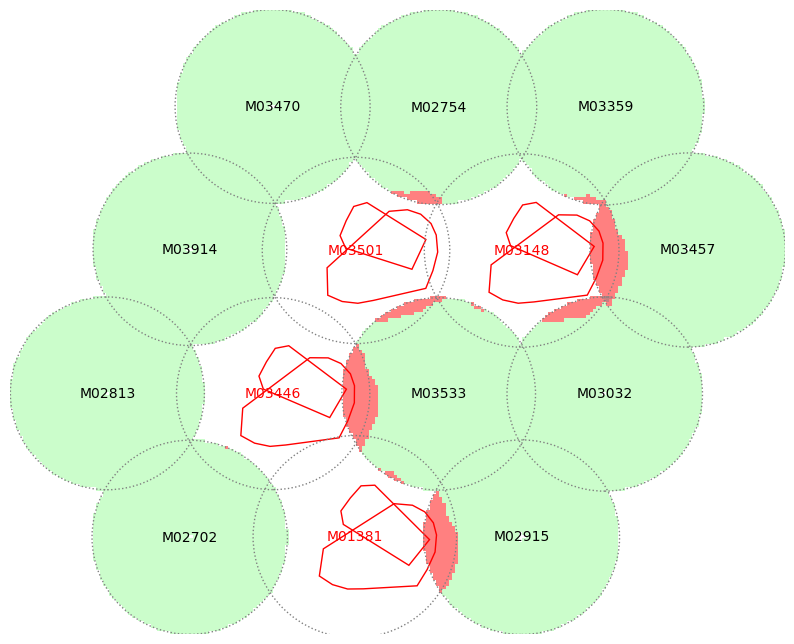

In [24]:
def plotGroup(group, calib, parkAngles=None, x0=57, y0=18, width=10):

    grid = initGrid(group, gridDensity=5, gridPad=6)
    angles, mapper, mask = getAngles(group, grid, calib)
    print(f'grid size: {grid.x.shape} with {mask.sum()} reachable points')

    if parkAngles is None:
        parkAngles = { }
        for posid in group.nonfunc:
            dev = lookup[posid]
            intT = dev['POS_T']
            extT = intT + dev['OFFSET_T']
            extP = np.round(dev['OFFSET_P'] + dev['POS_P'], 2)
            print(f'Using intT={intT:.2f}, extP={extP:.2f} for {posid}')
            parkAngles[posid] = (extT, extP)

    scores = getScores(grid, angles, mapper, parkAngles)
    print(f'Score: nblocked {scores.nblocked} ratio {100*scores.ratio:.1f}%')

    dxy = grid.spacing / 2
    xlo, xhi = grid.x.min() - dxy, grid.x.max() + dxy
    ylo, yhi = grid.y.min() - dxy, grid.y.max() + dxy
    fig, ax = plt.subplots(figsize=(width, width * (yhi - ylo) / (xhi - xlo)))
    ax.set(xlim=(xlo, xhi), ylim=(ylo, yhi), aspect=1)
    ax.axis('off')

    img = scores.array.astype(float)
    img[~mask] = np.nan
    cmap = ListedColormap(['palegreen', 'red', 'darkred'])
    norm = BoundaryNorm([0, 1, 2, 3], cmap.N)
    ax.imshow(img.T, origin='lower', extent=(xlo, xhi, ylo, yhi), alpha=0.5,
              aspect='auto', cmap=cmap, norm=norm, interpolation='none')

    for posid in group.nonfunc:
        T, P = np.deg2rad(parkAngles[posid])
        keepoutT, keepoutP = getRotatedKeepouts(posid, T, P, calib)
        ax.fill(*keepoutT.T, fc='none', ec='r')
        ax.fill(*keepoutP.T, fc='none', ec='r')

    for posid in group.func + group.nonfunc:
        dev = lookup[posid]
        xc, yc = dev['OFFSET_X'], dev['OFFSET_Y']
        r1, r2 = dev['LENGTH_R1'], dev['LENGTH_R2']
        ax.add_artist(plt.Circle((xc, yc), r1+r2, fc='none', ec='gray', ls=':'))
        ax.text(xc, yc, dev['POS_ID'], ha='center', va='center', fontsize=10,
                color='r' if dev['DEVICE_CLASSIFIED_NONFUNCTIONAL'] else 'k')

plotGroup(groups[2], calib)